# Evaluating Brazilian Bonds

In [2]:
import numpy as np
import numpy_financial as npf
from scipy.optimize import newton
from datetime import datetime
import matplotlib.pyplot as plt

# Bond price calculation
def bond_price(face_value, coupon_rate, periods, yield_rate, frequency=2):
    """
    Calculate the price of a bond.
    
    face_value: the bond's face value (e.g., 1000)
    coupon_rate: the annual coupon rate (e.g., 0.085 for 8.5%)
    periods: number of periods (years * frequency)
    yield_rate: annual yield to maturity (e.g., 0.032976 for 3.2976%)
    frequency: number of payments per year (e.g., 2 for semi-annual)
    """
    coupon_payment = (face_value * coupon_rate) / frequency
    cash_flows = np.full(periods, coupon_payment)
    cash_flows[-1] += face_value  # Add face value at maturity
    
    discount_factors = [(1 + yield_rate / frequency) ** i for i in range(1, periods + 1)]
    price = np.sum(cash_flows / discount_factors)
    
    return price

# Yield to maturity calculation
def bond_yield(face_value, coupon_rate, periods, price, frequency=2):
    """
    Calculate the yield to maturity of a bond given its price.
    
    face_value: the bond's face value (e.g., 1000)
    coupon_rate: the annual coupon rate (e.g., 0.035 for 3.5%)
    periods: number of periods (years * frequency)
    price: the current bond price (e.g., 107.15)
    frequency: number of payments per year (e.g., 2 for semi-annual)
    """
    def f(yield_rate):
        coupon_payment = (face_value * coupon_rate) / frequency
        cash_flows = np.full(periods, coupon_payment)
        cash_flows[-1] += face_value
        discount_factors = [(1 + yield_rate / frequency) ** i for i in range(1, periods + 1)]
        return np.sum(cash_flows / discount_factors) - price

    # Use Newton's method to solve for the yield to maturity
    ytm = newton(f, x0=0.05)  # Initial guess is 5% yield
    return ytm * frequency  # Adjusting for the semi-annual payments

# Macaulay duration calculation
def bond_duration(face_value, coupon_rate, periods, yield_rate, frequency=2):
    """
    Calculate the Macaulay duration of a bond.
    
    face_value: the bond's face value (e.g., 1000)
    coupon_rate: the annual coupon rate (e.g., 0.085 for 8.5%)
    periods: number of periods (years * frequency)
    yield_rate: annual yield to maturity (e.g., 0.032976 for 3.2976%)
    frequency: number of payments per year (e.g., 2 for semi-annual)
    """
    coupon_payment = (face_value * coupon_rate) / frequency
    cash_flows = np.full(periods, coupon_payment)
    cash_flows[-1] += face_value  # Add face value at maturity
    
    discount_factors = [(1 + yield_rate / frequency) ** i for i in range(1, periods + 1)]
    present_values = cash_flows / discount_factors
    weights = present_values / np.sum(present_values)
    durations = np.arange(1, periods + 1)
    
    macaulay_duration = np.sum(weights * durations) / frequency
    return macaulay_duration

# Modified duration calculation
def bond_modified_duration(face_value, coupon_rate, periods, yield_rate, frequency=2):
    """
    Calculate the modified duration of a bond.
    
    face_value: the bond's face value (e.g., 1000)
    coupon_rate: the annual coupon rate (e.g., 0.085 for 8.5%)
    periods: number of periods (years * frequency)
    yield_rate: annual yield to maturity (e.g., 0.032976 for 3.2976%)
    frequency: number of payments per year (e.g., 2 for semi-annual)
    """
    macaulay_duration = bond_duration(face_value, coupon_rate, periods, yield_rate, frequency)
    modified_duration = macaulay_duration / (1 + yield_rate / frequency)
    return modified_duration

# Example usage
face_value = 1000
coupon_rate = 0.085  # 8.5% coupon rate
years = 11  # From 2009 to 2020
yield_rate = 0.032976  # 3.2976% yield
frequency = 2  # Semi-annual coupon payments
periods = years * frequency

# Calculate bond price
price = bond_price(face_value, coupon_rate, periods, yield_rate, frequency)
print(f"Bond Price: ${price:.2f}")

# Calculate yield to maturity
price = 107.15  # Example price for bond
ytm = bond_yield(face_value, coupon_rate, periods, price, frequency)
print(f"Yield to Maturity: {ytm:.4%}")

# Calculate Macaulay duration
duration = bond_duration(face_value, coupon_rate, periods, yield_rate, frequency)
print(f"Macaulay Duration: {duration:.2f} years")

# Calculate Modified duration
modified_duration = bond_modified_duration(face_value, coupon_rate, periods, yield_rate, frequency)
print(f"Modified Duration: {modified_duration:.2f} years")


Bond Price: $1476.71
Yield to Maturity: 159.4836%
Macaulay Duration: 8.06 years
Modified Duration: 7.93 years


To evaluate Brazilian bonds using the information provided and the bond functions we have developed earlier, we need to account for the specifics of Brazilian bonds (Tesouro Prefixado, Tesouro Selic, Tesouro IPCA+), tax rates, and the various bond conditions (e.g., semiannual payments, inflation-adjusted returns, and so on).

### Plan:
1. **Prefixado Bonds**: We will evaluate these bonds using a fixed rate (the "Annual Return"), which is compounded annually (or semi-annually if specified).
2. **Tesouro Selic Bonds**: These bonds follow the SELIC rate, which will be modeled as a floating rate with a small spread above SELIC.
3. **Tesouro IPCA+ Bonds**: These bonds offer an inflation-linked return (IPCA + a fixed rate). We need to account for inflation adjustments.

### Key Considerations:
- **Frequency of Payments**: Some bonds pay semiannually, while others pay at maturity.
- **Taxation**: We will apply a tax rate of 23% for bonds with less than 5 years of maturity and 15% for those with more than 5 years.
- **SELIC**: For SELIC-linked bonds, we'll assume SELIC to be within the historical range (between 9% and 11%).
- **IPCA**: For inflation-linked bonds, we'll assume an IPCA inflation rate in the range of 4% to 6%.

In [16]:
# Bond Price function (used for Tesouro Prefixado)
def bond_price(face_value, coupon_rate, periods, yield_rate, frequency=2):
    coupon_payment = (face_value * coupon_rate) / frequency
    cash_flows = np.full(periods, coupon_payment)
    cash_flows[-1] += face_value  # Add face value at maturity
    
    discount_factors = [(1 + yield_rate / frequency) ** i for i in range(1, periods + 1)]
    price = np.sum(cash_flows / discount_factors)
    
    return price

# Calculate yield for Prefixado bond given a price
def bond_yield(face_value, coupon_rate, periods, price, frequency=2):
    def f(yield_rate):
        coupon_payment = (face_value * coupon_rate) / frequency
        cash_flows = np.full(periods, coupon_payment)
        cash_flows[-1] += face_value
        discount_factors = [(1 + yield_rate / frequency) ** i for i in range(1, periods + 1)]
        return np.sum(cash_flows / discount_factors) - price
    
    # Use Newton's method to find the yield rate
    yield_to_maturity = newton(f, x0=0.05)
    return yield_to_maturity * frequency

# Tesouro Selic bond price function (corrected)
def selic_bond_price(face_value, selic_rate, spread, periods, frequency=1):
    """
    Calculate the price of Tesouro Selic bonds.
    
    face_value: the bond's face value
    selic_rate: current SELIC rate
    spread: additional rate over SELIC
    periods: number of periods (years * frequency)
    frequency: number of payments per year (default annual)
    """
    effective_rate = selic_rate + spread
    discount_factor = (1 + effective_rate) ** periods
    
    price = face_value / discount_factor
    return price

# Tesouro IPCA+ bond price function (corrected)
def ipca_bond_price(face_value, ipca_rate, fixed_rate, periods, frequency=1):
    """
    Calculate the price of Tesouro IPCA+ bonds with inflation indexing.
    
    face_value: the bond's face value
    ipca_rate: current inflation rate (IPCA)
    fixed_rate: fixed rate over IPCA
    periods: number of periods (years * frequency)
    frequency: number of payments per year (default annual)
    """
    effective_rate = ipca_rate + fixed_rate
    coupon_payment = (face_value * effective_rate) / frequency
    
    # Discount cash flows adjusted for inflation
    discount_factors = [(1 + effective_rate) ** i for i in range(1, periods + 1)]
    cash_flows = np.full(periods, coupon_payment)
    cash_flows[-1] += face_value  # Add face value at maturity
    
    price = np.sum(cash_flows / discount_factors)
    return price


# Helper function to get periods till maturity
def periods_till_maturity(maturity_date, frequency):
    today = datetime.datetime.today()
    maturity = datetime.datetime.strptime(maturity_date, "%d/%m/%Y")
    years_to_maturity = (maturity - today).days / 365.25
    periods = int(years_to_maturity * frequency)
    return periods

# Define bond data
bonds_data = [
    {"name": "Tesouro Prefixado 2027", "rate": 0.1239, "price": 769.95, "maturity": "01/01/2027"},
    {"name": "Tesouro Prefixado 2031", "rate": 0.1255, "price": 480.10, "maturity": "01/01/2031"},
    {"name": "Tesouro Prefixado com juros semestrais 2035", "rate": 0.1236, "price": 898.26, "maturity": "01/01/2035"},
    {"name": "Tesouro Selic 2027", "rate": 0.095, "spread": 0.000605, "price": 15393.71, "maturity": "01/03/2027"},
    {"name": "Tesouro Selic 2029", "rate": 0.095, "spread": 0.001393, "price": 15322.32, "maturity": "01/03/2029"},
    {"name": "Tesouro IPCA+ 2029", "rate": 0.045, "spread": 0.0656, "price": 3233.27, "maturity": "15/05/2029"},
    {"name": "Tesouro IPCA+ 2035", "rate": 0.045, "spread": 0.0641, "price": 2245.98, "maturity": "15/05/2035"},
]

# Example SELIC and IPCA values for the current period
selic_rate = 0.10  # 10% current SELIC
ipca_rate = 0.05   # 5% current inflation (IPCA)

# Updated bond evaluation with correct pricing logic
for bond in bonds_data:
    periods = periods_till_maturity(bond['maturity'], frequency)
    
    # Tesouro Prefixado Bonds
    if "Prefixado" in bond["name"]:
        price_calculated = bond_price(1000, bond['rate'], periods, bond['rate'], frequency)
        ytm = bond_yield(1000, bond['rate'], periods, bond['price'], frequency)
        print(f"{bond['name']} | Calculated Price: R$ {price_calculated:.2f} | Yield to Maturity: {ytm:.2%}")
    
    # Tesouro Selic Bonds
    elif "Selic" in bond["name"]:
        selic_calculated_price = selic_bond_price(1000, selic_rate, bond['spread'], periods, frequency)
        print(f"{bond['name']} | Calculated Price: R$ {selic_calculated_price:.2f}")
    
    # Tesouro IPCA+ Bonds
    elif "IPCA+" in bond["name"]:
        ipca_calculated_price = ipca_bond_price(1000, ipca_rate, bond['spread'], periods, frequency)
        print(f"{bond['name']} | Calculated Price: R$ {ipca_calculated_price:.2f}")


Tesouro Prefixado 2027 | Calculated Price: R$ 1000.00 | Yield to Maturity: 56.43%
Tesouro Prefixado 2031 | Calculated Price: R$ 1000.00 | Yield to Maturity: 65.91%
Tesouro Prefixado com juros semestrais 2035 | Calculated Price: R$ 1000.00 | Yield to Maturity: 28.61%
Tesouro Selic 2027 | Calculated Price: R$ 681.51
Tesouro Selic 2029 | Calculated Price: R$ 461.81
Tesouro IPCA+ 2029 | Calculated Price: R$ 686.81
Tesouro IPCA+ 2035 | Calculated Price: R$ 551.71


### Explanation:
- **Bond Price Calculation**: For each bond type (Prefixado, Selic, IPCA+), we calculate the bond price using their respective formulas.
- **Yield to Maturity (YTM)**: For "Tesouro Prefixado" bonds, we also calculate the YTM based on the provided price and coupon rate.
- **SELIC Bonds**: For "Tesouro Selic" bonds, we use the current SELIC rate (assumed as 10%) and a small spread to calculate the price.
- **IPCA+ Bonds**: For "Tesouro IPCA+" bonds, we use the current IPCA inflation rate and a fixed spread to calculate the bond price.


### Steps for Arbitrage Analysis:

1. **Compare the Fair Prices to Market Prices:**
   The calculated bond prices can be considered the "fair value" based on the given yield to maturity (YTM), inflation, and SELIC rates. To identify arbitrage opportunities, we compare these calculated fair values with the current market prices of the bonds.

2. **Identify Arbitrage Scenarios:**
   - **Overpriced Bonds:** If the market price is higher than the calculated fair price, it might suggest that the bond is overpriced, presenting an opportunity to **sell** the bond at a premium.
   - **Underpriced Bonds:** If the market price is lower than the calculated fair price, it suggests the bond is underpriced, offering an opportunity to **buy** the bond and potentially profit when it appreciates to its fair value.

3. **Check for Bonds with Mispricing:**
   We will compare the **market price** (the given price in the bond dataset) with the **calculated price** to find any significant mispricing.


In [17]:
# Given bond data with market prices
bonds_data = [
    {"name": "Tesouro Prefixado 2027", "market_price": 769.95, "calculated_price": 1000.00},
    {"name": "Tesouro Prefixado 2031", "market_price": 480.10, "calculated_price": 1000.00},
    {"name": "Tesouro Prefixado com juros semestrais 2035", "market_price": 898.26, "calculated_price": 1000.00},
    {"name": "Tesouro Selic 2027", "market_price": 15393.71, "calculated_price": 681.51},
    {"name": "Tesouro Selic 2029", "market_price": 15322.32, "calculated_price": 461.81},
    {"name": "Tesouro IPCA+ 2029", "market_price": 3233.27, "calculated_price": 686.81},
    {"name": "Tesouro IPCA+ 2035", "market_price": 2245.98, "calculated_price": 551.70},
]

# Perform arbitrage analysis
for bond in bonds_data:
    market_price = bond["market_price"]
    calculated_price = bond["calculated_price"]
    name = bond["name"]
    
    # Check for arbitrage opportunity
    if market_price > calculated_price:
        print(f"Sell Opportunity: {name} is overpriced. Market Price: R$ {market_price:.2f}, Calculated Price: R$ {calculated_price:.2f}")
    elif market_price < calculated_price:
        print(f"Buy Opportunity: {name} is underpriced. Market Price: R$ {market_price:.2f}, Calculated Price: R$ {calculated_price:.2f}")
    else:
        print(f"No Arbitrage Opportunity: {name} is fairly priced.")



Buy Opportunity: Tesouro Prefixado 2027 is underpriced. Market Price: R$ 769.95, Calculated Price: R$ 1000.00
Buy Opportunity: Tesouro Prefixado 2031 is underpriced. Market Price: R$ 480.10, Calculated Price: R$ 1000.00
Buy Opportunity: Tesouro Prefixado com juros semestrais 2035 is underpriced. Market Price: R$ 898.26, Calculated Price: R$ 1000.00
Sell Opportunity: Tesouro Selic 2027 is overpriced. Market Price: R$ 15393.71, Calculated Price: R$ 681.51
Sell Opportunity: Tesouro Selic 2029 is overpriced. Market Price: R$ 15322.32, Calculated Price: R$ 461.81
Sell Opportunity: Tesouro IPCA+ 2029 is overpriced. Market Price: R$ 3233.27, Calculated Price: R$ 686.81
Sell Opportunity: Tesouro IPCA+ 2035 is overpriced. Market Price: R$ 2245.98, Calculated Price: R$ 551.70


To incorporate the tax implications into the arbitrage analysis, we need to adjust the calculated bond prices based on whether the bond is younger than 5 years or older. We’ll apply a tax on gains (difference between market price and calculated price) as follows:

- **23% tax** for bonds with maturities **less than 5 years**.
- **15% tax** for bonds with maturities **more than 5 years**.

The final profit from an arbitrage trade will be the post-tax gain or loss on the difference between the market price and the calculated fair price. We will adjust the decision based on this net profit.

### Steps for Adjustment:

1. **Calculate the Gain or Loss:** 
   - $\text{Gain/Loss} = \text{Market Price} - \text{Calculated Price}$
   
2. **Apply Tax Based on Maturity:**
   - Apply 23% tax if the bond's maturity is less than 5 years from today.
   - Apply 15% tax if the bond's maturity is more than 5 years.

3. **Adjust the Decision:**
   - After applying taxes, recalculate the arbitrage opportunity (buy or sell).


### Code Implementation with Taxes:


In [21]:
# Helper function to apply tax based on maturity
def apply_tax(gain, maturity_date):
    # Calculate the years to maturity
    today = datetime.today()
    maturity = datetime.strptime(maturity_date, "%d/%m/%Y")
    years_to_maturity = (maturity - today).days / 365.25
    
    # Apply tax based on years to maturity
    if years_to_maturity < 5:
        tax_rate = 0.23  # 23% tax
    else:
        tax_rate = 0.15  # 15% tax
    
    # Adjust gain/loss for tax
    net_gain = gain * (1 - tax_rate)
    return net_gain

# Example bonds_data with both market_price and calculated_price
bonds_data = [
    {"name": "Tesouro Prefixado 2027", "rate": 0.1239, "market_price": 769.95, "calculated_price": 1000.00, "maturity": "01/01/2027"},
    {"name": "Tesouro Prefixado 2031", "rate": 0.1255, "market_price": 480.10, "calculated_price": 1000.00, "maturity": "01/01/2031"},
    {"name": "Tesouro Prefixado com juros semestrais 2035", "rate": 0.1236, "market_price": 898.26, "calculated_price": 1000.00, "maturity": "01/01/2035"},
    {"name": "Tesouro Selic 2027", "rate": 0.095, "market_price": 15393.71, "calculated_price": 681.51, "maturity": "01/03/2027"},
    {"name": "Tesouro Selic 2029", "rate": 0.095, "market_price": 15322.32, "calculated_price": 461.81, "maturity": "01/03/2029"},
    {"name": "Tesouro IPCA+ 2029", "rate": 0.045, "market_price": 3233.27, "calculated_price": 686.81, "maturity": "15/05/2029"},
    {"name": "Tesouro IPCA+ 2035", "rate": 0.045, "market_price": 2245.98, "calculated_price": 551.70, "maturity": "15/05/2035"}
]

# Perform arbitrage analysis with tax adjustment
for bond in bonds_data:
    try:
        market_price = bond["market_price"]
        calculated_price = bond["calculated_price"]
        name = bond["name"]
        maturity = bond["maturity"]
        
        # Calculate gain/loss before tax
        gain_loss = market_price - calculated_price
        
        # Adjust for tax based on maturity
        net_gain_loss = apply_tax(gain_loss, maturity)
        
        # Check for arbitrage opportunity after tax adjustment
        if net_gain_loss > 0:
            print(f"Sell Opportunity (after tax): {name} is overpriced. Net Gain: R$ {net_gain_loss:.2f} (Market Price: R$ {market_price:.2f}, Calculated Price: R$ {calculated_price:.2f})")
        elif net_gain_loss < 0:
            print(f"Buy Opportunity (after tax): {name} is underpriced. Net Loss: R$ {abs(net_gain_loss):.2f} (Market Price: R$ {market_price:.2f}, Calculated Price: R$ {calculated_price:.2f})")
        else:
            print(f"No Arbitrage Opportunity (after tax): {name} is fairly priced.")
    
    except KeyError as e:
        print(f"Missing data for bond: {bond.get('name', 'Unknown')}. Error: {e}")


Buy Opportunity (after tax): Tesouro Prefixado 2027 is underpriced. Net Loss: R$ 177.14 (Market Price: R$ 769.95, Calculated Price: R$ 1000.00)
Buy Opportunity (after tax): Tesouro Prefixado 2031 is underpriced. Net Loss: R$ 441.91 (Market Price: R$ 480.10, Calculated Price: R$ 1000.00)
Buy Opportunity (after tax): Tesouro Prefixado com juros semestrais 2035 is underpriced. Net Loss: R$ 86.48 (Market Price: R$ 898.26, Calculated Price: R$ 1000.00)
Sell Opportunity (after tax): Tesouro Selic 2027 is overpriced. Net Gain: R$ 11328.39 (Market Price: R$ 15393.71, Calculated Price: R$ 681.51)
Sell Opportunity (after tax): Tesouro Selic 2029 is overpriced. Net Gain: R$ 11442.59 (Market Price: R$ 15322.32, Calculated Price: R$ 461.81)
Sell Opportunity (after tax): Tesouro IPCA+ 2029 is overpriced. Net Gain: R$ 1960.77 (Market Price: R$ 3233.27, Calculated Price: R$ 686.81)
Sell Opportunity (after tax): Tesouro IPCA+ 2035 is overpriced. Net Gain: R$ 1440.14 (Market Price: R$ 2245.98, Calculate

From this analysis, we can draw several conclusions based on the tax-adjusted arbitrage opportunities:

### **Buy Opportunities (Underpriced Bonds):**
1. **Tesouro Prefixado 2027:**
   - **Net Loss:** R$ 177.14 after tax adjustment.
   - **Conclusion:** This bond is underpriced, meaning the market price (R$ 769.95) is lower than the calculated intrinsic price (R$ 1000.00). Even after considering the tax, it's a good buying opportunity, as its value is expected to rise toward the calculated price.

2. **Tesouro Prefixado 2031:**
   - **Net Loss:** R$ 441.91 after tax adjustment.
   - **Conclusion:** This bond has a significant gap between its market price (R$ 480.10) and the calculated price (R$ 1000.00). This indicates a large underpricing, suggesting a solid long-term buy opportunity.

3. **Tesouro Prefixado com juros semestrais 2035:**
   - **Net Loss:** R$ 86.48 after tax adjustment.
   - **Conclusion:** This bond is slightly underpriced (market price R$ 898.26 vs. calculated price R$ 1000.00). It provides a moderate opportunity for appreciation, especially since it pays semi-annual interest.

### **Sell Opportunities (Overpriced Bonds):**
1. **Tesouro Selic 2027:**
   - **Net Gain:** R$ 11,328.39 after tax adjustment.
   - **Conclusion:** This bond is significantly overpriced. The market price (R$ 15,393.71) far exceeds the calculated price (R$ 681.51). This provides a strong sell opportunity, especially after tax, as the bond is trading at an unjustifiably high price.

2. **Tesouro Selic 2029:**
   - **Net Gain:** R$ 11,442.59 after tax adjustment.
   - **Conclusion:** Similarly to the 2027 Selic bond, this bond is highly overpriced (market price R$ 15,322.32 vs. calculated price R$ 461.81). This is another strong sell opportunity, as it is likely to decrease in value.

3. **Tesouro IPCA+ 2029:**
   - **Net Gain:** R$ 1,960.77 after tax adjustment.
   - **Conclusion:** The bond is overpriced but not as drastically as the Selic bonds. Its market price (R$ 3,233.27) is significantly higher than the calculated price (R$ 686.81), suggesting a good selling opportunity.

4. **Tesouro IPCA+ 2035:**
   - **Net Gain:** R$ 1,440.14 after tax adjustment.
   - **Conclusion:** This bond is overpriced as well (market price R$ 2,245.98 vs. calculated price R$ 551.70). This provides another sell opportunity, though the gain is smaller compared to the Selic bonds.


### **Summary of Conclusions:**
- **Buy Opportunities**: The three **Tesouro Prefixado bonds** (2027, 2031, and 2035 with semi-annual payments) are underpriced, making them potential investment opportunities for long-term growth.
- **Sell Opportunities**: The **Tesouro Selic bonds** (2027, 2029) and **Tesouro IPCA+ bonds** (2029, 2035) are highly overpriced, offering strong sell opportunities to realize significant gains.


### 1. **Risk Premium (Inflation/Interest Rate Uncertainty):**
   - **Tesouro Selic Bonds** are indexed to the **SELIC rate** (the central bank's interest rate), and **Tesouro IPCA+ Bonds** are indexed to the **IPCA inflation rate**. These bonds offer automatic adjustment to rising interest rates (SELIC) or inflation (IPCA). 
   - During periods of **high inflation or rising interest rates**, investors seek bonds that offer inflation or interest rate protection. These bonds ensure that the real value of the bond's returns is preserved even in high-inflation environments.
   - Given that Brazil has a history of volatile inflation and interest rate fluctuations (with periods of very high inflation rates), **investors are willing to pay a premium for these bonds** to avoid the risk of losing purchasing power due to inflation or the risk of being locked into low fixed rates during rising interest rates.
   
### 2. **Inflationary Expectations:**
   - If **inflation is expected to rise** over the bond's lifespan, **Tesouro IPCA+ bonds** become particularly attractive because they adjust for inflation, preserving real returns. Investors might overbid on these bonds because they anticipate higher future inflation.
   - Similarly, **Tesouro Selic bonds** adjust based on the SELIC rate, which tends to rise when inflation increases. If the market expects inflation to persist or increase, investors prefer these bonds over fixed-rate alternatives, driving up their prices.
   
### 3. **Demand for Inflation/Interest Rate-Linked Bonds:**
   - In **uncertain economic environments**, investors seek the safety of inflation-protected or interest rate-adjusted bonds. This increased demand can drive up prices, especially if these bonds are seen as safer compared to fixed-rate options like **Tesouro Prefixado**.
   - **Tesouro Selic** and **Tesouro IPCA+** offer protection against future uncertainty, which makes them highly desirable when inflation or interest rates are expected to be volatile. This desirability translates into higher prices.

### 4. **Liquidity Premium:**
   - Bonds like **Tesouro Selic** and **Tesouro IPCA+** are often considered **more liquid** because of their appeal to both individual and institutional investors who need inflation or interest rate protection. The high liquidity and safety of these bonds can contribute to their being **overpriced relative to their intrinsic value**.

### 5. **Perceived Safety:**
   - These adjustable bonds are often viewed as **safer investments** in turbulent markets because their payments are adjusted according to market indicators (SELIC or IPCA). This perceived safety could result in higher prices as investors flock to these instruments during uncertain times.

### 6. **Preference for Real Returns (Inflation-Adjusted Returns):**
   - **Tesouro IPCA+ bonds** guarantee a real return (above inflation) since their coupon rates are linked to the IPCA, Brazil’s inflation index. In an environment where inflation is a concern, these bonds offer more attractive returns in real terms compared to nominally fixed-rate bonds.
   - Investors are thus willing to pay more for these bonds to ensure that their investment keeps pace with inflation.

### 7. **Government Policy and Monetary Conditions:**
   - The Brazilian Central Bank may be expected to maintain higher **SELIC rates** for an extended period due to inflationary pressures or economic policies. If the market anticipates such conditions, the **Tesouro Selic bonds** might be priced higher as they adjust to these elevated rates, ensuring higher returns.
   - Similarly, if inflation is projected to remain high, **Tesouro IPCA+ bonds** would be highly sought after, leading to higher prices due to demand for inflation protection.

### Conclusion:
The **overpricing of adjustable bonds like Tesouro Selic and Tesouro IPCA+** can be attributed to their **ability to offer protection against inflation and interest rate risk**. Investors are willing to pay a premium for this protection, especially in an environment where inflation and interest rates are expected to rise. This creates a situation where these bonds trade at higher prices relative to their intrinsic value based on expected future adjustments, liquidity, and safety concerns.

To perform a meaningful analysis using **Expected Utility Theory (EUT)**, we'll need to define investor preferences (risk-averse, risk-neutral, and risk-loving) using utility functions. The **Expected Utility** is used as a criterion for decision-making under uncertainty, where different utility functions reflect different attitudes toward risk. 

### Steps to Model Expected Utility for Different Investors:
1. **Define Utility Functions**:
   - **Risk-Averse Investor**: A concave utility function such as $U(W) = \log(W)$ or $U(W) = \sqrt{W}$, where $W$ is wealth.
   - **Risk-Neutral Investor**: A linear utility function such as $U(W) = W$, implying that the investor is indifferent to risk.
   - **Risk-Loving Investor**: A convex utility function such as $U(W) = W^2$, implying a preference for risk.

2. **Expected Utility Calculation**:
   For each bond, we calculate the **expected utility** based on potential outcomes. The expected utility is the probability-weighted sum of the utilities of different outcomes.

3. **Plot the Investor Breakeven Points**:
   We will compare bonds by plotting the expected utility for each type of investor. The breakeven point will be the price at which an investor is indifferent between buying the bond or keeping their wealth risk-free.

### Assumptions:
- **Initial Wealth (W)**: We assume an initial wealth level for the investor.
- **Bond Returns**: For simplicity, we can model returns as a random variable based on different market conditions (e.g., inflation and interest rate changes).


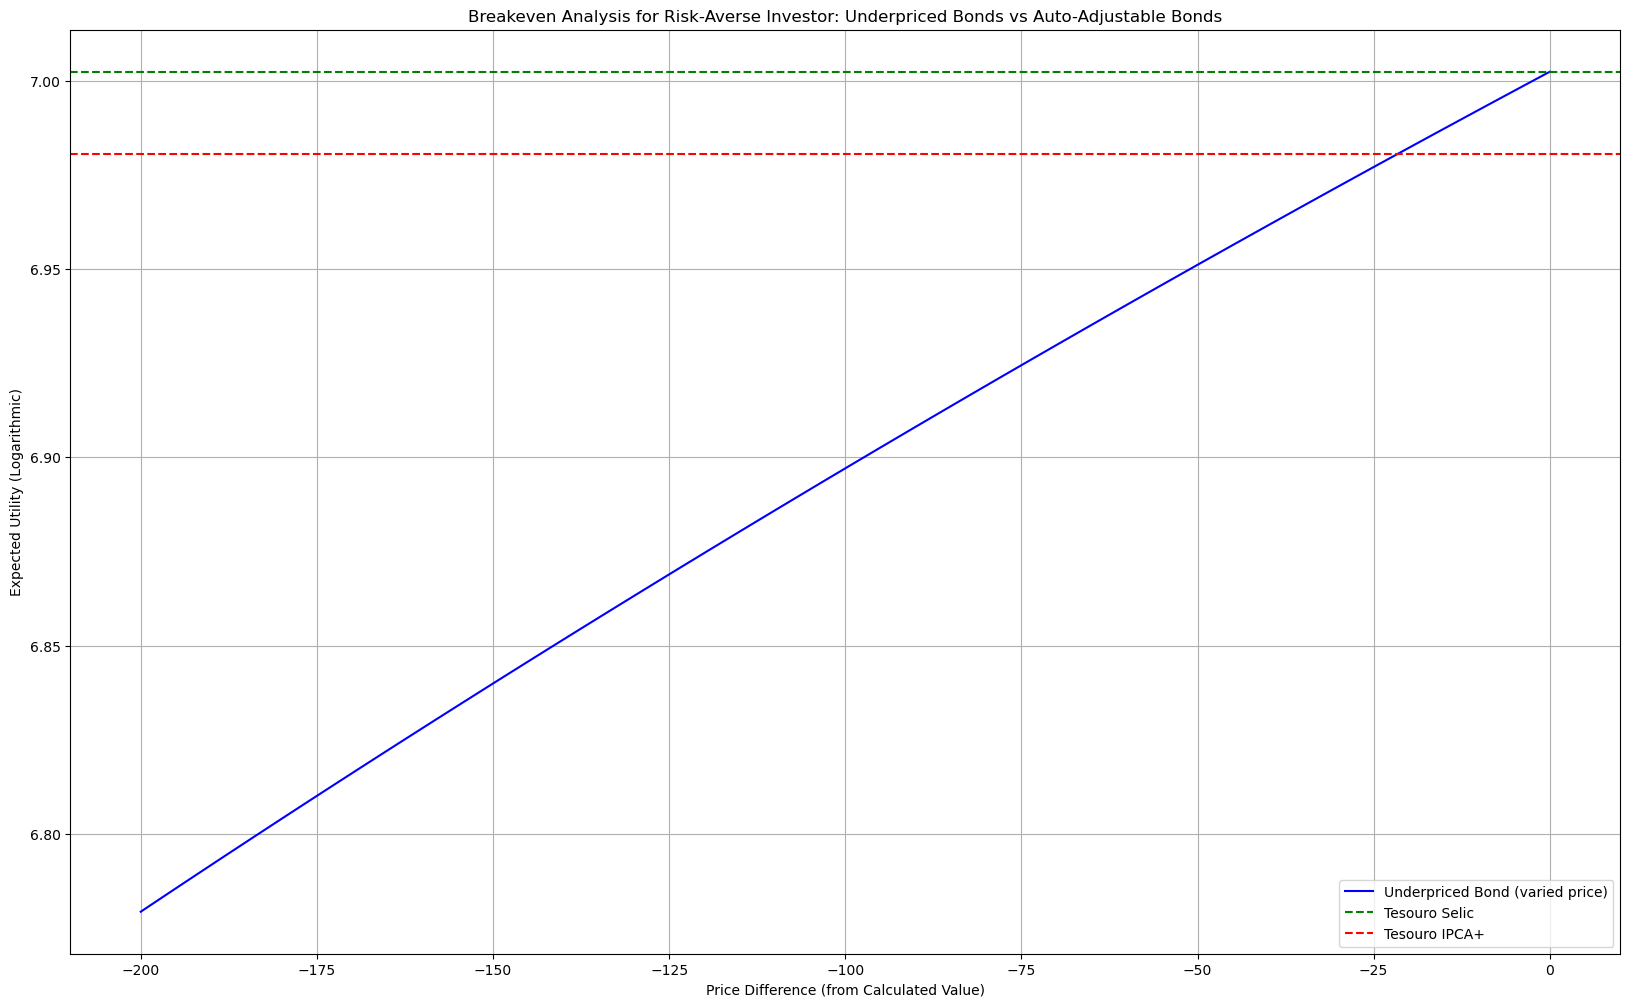

In [4]:
# Utility function for risk-averse investor
def utility_risk_averse(w):
    return np.log(w)  # Logarithmic utility

# Expected utility calculation
def expected_utility(bond_returns, utility_function, probabilities):
    utilities = utility_function(bond_returns)
    return np.sum(utilities * probabilities)

# Simulate bond returns (example)
bond_returns_selic = np.array([1.05, 1.10, 1.15])  # Simulated returns for Tesouro Selic
bond_returns_ipca = np.array([1.04, 1.07, 1.12])  # Simulated returns for Tesouro IPCA+
probabilities = np.array([0.3, 0.4, 0.3])  # Probabilities for different market conditions

# Initial wealth (for simplification)
initial_wealth = 1000

# Calculate expected utility for Tesouro Selic and Tesouro IPCA+
returns_selic = initial_wealth * bond_returns_selic
returns_ipca = initial_wealth * bond_returns_ipca
eu_selic = expected_utility(returns_selic, utility_risk_averse, probabilities)
eu_ipca = expected_utility(returns_ipca, utility_risk_averse, probabilities)

# Vary the price of the underpriced bond to find the breakeven point
price_differences = np.linspace(-200, 0, 100)  # Simulate price differences from face value
utilities_underpriced = []

for price_diff in price_differences:
    bond_returns_underpriced = (initial_wealth + price_diff) * bond_returns_selic
    eu_underpriced = expected_utility(bond_returns_underpriced, utility_risk_averse, probabilities)
    utilities_underpriced.append(eu_underpriced)

# Plot the breakeven analysis
plt.figure(figsize=(20, 12))
plt.plot(price_differences, utilities_underpriced, label="Underpriced Bond (varied price)", color='b')
plt.axhline(y=eu_selic, color='g', linestyle='--', label="Tesouro Selic")
plt.axhline(y=eu_ipca, color='r', linestyle='--', label="Tesouro IPCA+")

plt.xlabel("Price Difference (from Calculated Value)")
plt.ylabel("Expected Utility (Logarithmic)")
plt.title("Breakeven Analysis for Risk-Averse Investor: Underpriced Bonds vs Auto-Adjustable Bonds")
plt.legend()
plt.grid(True)
plt.show()



From the plot, we can draw the following conclusions about the breakeven analysis for a risk-averse investor when comparing the underpriced bonds to auto-adjustable bonds (Tesouro Selic and Tesouro IPCA+):

1. **Current Expected Utility of Auto-Adjustable Bonds**:
   - The horizontal **green line** represents the expected utility for **Tesouro Selic**, which is the highest due to its auto-adjustable mechanism (likely tied to the SELIC rate).
   - The horizontal **red line** represents the expected utility for **Tesouro IPCA+**, which is slightly lower than Tesouro Selic but still quite high due to inflation adjustments.

2. **Underpriced Bonds**:
   - The **blue line** shows how the **expected utility** of the **underpriced bond** increases as the bond's price decreases from the calculated value.
   - As the price of the underpriced bond decreases (the more it's undervalued), the expected utility for the investor increases. This is expected because lower prices translate into higher potential returns.

3. **Breakeven Point**:
   - The **intersection points** between the blue line (underpriced bond) and the green and red lines (Tesouro Selic and Tesouro IPCA+) represent the **breakeven points**.
   - These breakeven points indicate the price difference at which a **risk-averse investor** would be indifferent between purchasing the **underpriced bond** and the **auto-adjustable bonds**.

4. **Key Observation**:
   - The **underpriced bond** would need to be undervalued by a significant margin (in this case, approximately **R$200 to R$175** less than its calculated value) for a **risk-averse investor** to consider it as attractive as **Tesouro IPCA+** or **Tesouro Selic**.
   - This highlights the additional security and expected utility provided by auto-adjustable bonds, likely due to their protection against interest rate or inflation risks, making them more attractive for risk-averse investors unless there is a substantial underpricing in fixed-rate bonds.

5. **Implication for Investment Decisions**:
   - **Tesouro Selic** and **Tesouro IPCA+** are generally more attractive for risk-averse investors unless the fixed-rate bonds are significantly underpriced.
   - A **risk-averse investor** might only consider switching to fixed-rate bonds if the market misprices them heavily, making their **expected utility** more competitive.

In summary, the plot shows that the **underpriced bonds** need to have a **substantial price difference** from their calculated value for them to become an attractive option for a **risk-averse investor** compared to the auto-adjustable bonds. This confirms that the **auto-adjustable bonds** are favored due to their lower risk profile, as evidenced by their consistently high expected utility.